# ViT Fine-tuning

El presente notebook es el proceso de fine-tuning para [ViT](https://huggingface.co/google/vit-base-patch16-224).

Autores:

Esp. Abraham Rodriguez
Mg. Oksana Bokhonok

In [2]:
# pip install datasets transformers

In [3]:
import torch
from torch.utils.data import DataLoader
from datasets import load_dataset
#from transformers import MobileViTForImageClassification, MobileViTImageProcessor
from transformers import ViTForImageClassification, ViTImageProcessor
from transformers import TrainingArguments, Trainer
import matplotlib.pyplot as plt
import numpy as np

In [4]:
device =  'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print(device) # Expected: ‘cuda’ if Linux else ‘mps’ if MacOS
device =  'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

cuda


# Descargando modelos

In [5]:
dataset = load_dataset('cifar10')

README.md:   0%|          | 0.00/5.16k [00:00<?, ?B/s]

d:\Users\juanp_schamun\AppData\Local\anaconda3\envs\ViT\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in D:\Users\juanp_schamun\.cache\huggingface\hub\datasets--cifar10. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


train-00000-of-00001.parquet:   0%|          | 0.00/120M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/23.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 10000
    })
})

In [8]:
train_dataset = load_dataset('cifar10', split='train[:4000]')
test_dataset = load_dataset('cifar10', split='test[:2000]')

In [9]:
id2label = {id:label for id, label in enumerate(train_dataset.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}
id2label

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [10]:
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

d:\Users\juanp_schamun\AppData\Local\anaconda3\envs\ViT\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in D:\Users\juanp_schamun\.cache\huggingface\hub\models--google--vit-base-patch16-224. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

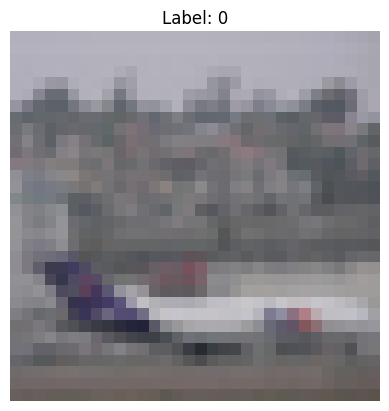

In [11]:
item = train_dataset[0]  # For example, the first image in the dataset

# Display the image
plt.imshow(item['img'])
plt.title(f"Label: {item['label']}")
plt.axis('off')  # Hide the axes for clarity
plt.show()

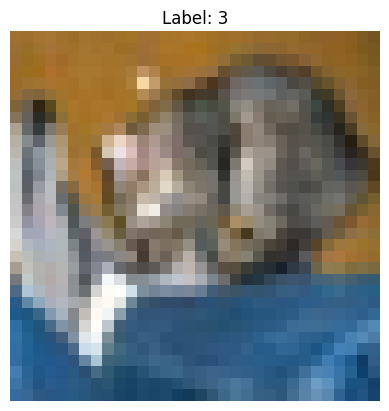

In [12]:
item = test_dataset[0]  # For example, the first image in the dataset

# Display the image
plt.imshow(item['img'])
plt.title(f"Label: {item['label']}")
plt.axis('off')  # Hide the axes for clarity
plt.show()

In [13]:
torch.set_float32_matmul_precision("medium") # optimizacion

In [14]:
def preprocess_function(examples):
    inputs = processor(images=examples['img'], return_tensors="pt", padding=True)
    inputs['labels'] = torch.tensor([0] * len(examples['label']), dtype=torch.float)
    return inputs

In [16]:

def transform(example):
    # Apply feature extractor transforms (resize, normalize, convert to tensor)
    inputs = processor(images=example['img'], return_tensors="pt")
    example['pixel_values'] = inputs['pixel_values'].squeeze()  # Remove extra dimension
    example['label'] = example['label']
    return example


train_dataset = train_dataset.map(transform)
test_dataset = test_dataset.map(transform)


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [17]:
train_dataset.set_format(type='torch', columns=['pixel_values', 'label'])
test_dataset.set_format(type='torch', columns=['pixel_values', 'label'])

In [18]:
test_dataset

Dataset({
    features: ['img', 'label', 'pixel_values'],
    num_rows: 2000
})

# Fine-tuning

In [19]:
import os
os.environ["WANDB_DISABLED"] = "true" # no utilizamos weights and biases

In [20]:
training_args = TrainingArguments(
    output_dir="./vit-finetuned-cifar10",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    log_level = 'info',
    fp16 = True,
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    accuracy = np.mean(preds == labels)
    return {"accuracy": accuracy}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    #compute_metrics=compute_metrics,
)

trainer.train()

d:\Users\juanp_schamun\AppData\Local\anaconda3\envs\ViT\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using auto half precision backend
The following columns in the training set don't have a corresponding argument in `ViTForImageClassification.forward` and have been ignored: img. If img are not expected by `ViTForImageClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 4,000
  Num Epochs = 3
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 189
  Number 

  0%|          | 0/189 [00:00<?, ?it/s]

The following columns in the evaluation set don't have a corresponding argument in `ViTForImageClassification.forward` and have been ignored: img. If img are not expected by `ViTForImageClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 2000
  Batch size = 64


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 1.1245136260986328, 'eval_runtime': 19.5314, 'eval_samples_per_second': 102.399, 'eval_steps_per_second': 1.638, 'epoch': 1.0}


The following columns in the evaluation set don't have a corresponding argument in `ViTForImageClassification.forward` and have been ignored: img. If img are not expected by `ViTForImageClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 2000
  Batch size = 64


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.42167237401008606, 'eval_runtime': 21.3153, 'eval_samples_per_second': 93.829, 'eval_steps_per_second': 1.501, 'epoch': 2.0}


Saving model checkpoint to ./vit-finetuned-cifar10\checkpoint-189
Configuration saved in ./vit-finetuned-cifar10\checkpoint-189\config.json
Model weights saved in ./vit-finetuned-cifar10\checkpoint-189\model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `ViTForImageClassification.forward` and have been ignored: img. If img are not expected by `ViTForImageClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 2000
  Batch size = 64


  0%|          | 0/32 [00:00<?, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)




{'eval_loss': 0.34864819049835205, 'eval_runtime': 20.1943, 'eval_samples_per_second': 99.038, 'eval_steps_per_second': 1.585, 'epoch': 3.0}
{'train_runtime': 220.5484, 'train_samples_per_second': 54.41, 'train_steps_per_second': 0.857, 'train_loss': 1.7107937928860781, 'epoch': 3.0}


TrainOutput(global_step=189, training_loss=1.7107937928860781, metrics={'train_runtime': 220.5484, 'train_samples_per_second': 54.41, 'train_steps_per_second': 0.857, 'total_flos': 9.38221640810496e+17, 'train_loss': 1.7107937928860781, 'epoch': 3.0})

In [21]:
eval_results = trainer.evaluate()
print(eval_results)

The following columns in the evaluation set don't have a corresponding argument in `ViTForImageClassification.forward` and have been ignored: img. If img are not expected by `ViTForImageClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 2000
  Batch size = 64


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.34864819049835205, 'eval_runtime': 17.1956, 'eval_samples_per_second': 116.309, 'eval_steps_per_second': 1.861, 'epoch': 3.0}


In [22]:
torch.cuda.empty_cache() # limpiamos cache

# Pruebas

In [23]:
test_loader = DataLoader(test_dataset, batch_size=32)

# Evaluate the model on test data
model.eval()  # Set model to evaluation mode
correct = 0
total = 0

with torch.no_grad():
    for batch in test_loader:
        pixel_values = batch['pixel_values'].squeeze(1).float()
        outputs = model(pixel_values=pixel_values.to('cuda'))  # Forward pass
        predictions = torch.argmax(outputs.logits, dim=-1)
        correct += (predictions.to('cpu') == batch['label']).sum().item()
        total += batch['label'].size(0)

accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 89.55%


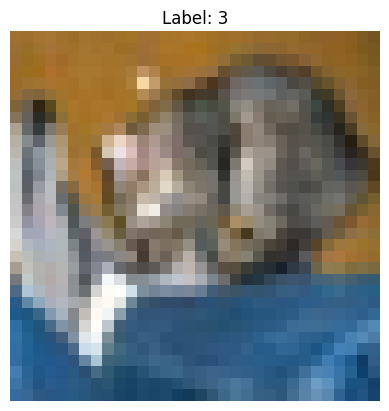

In [25]:
test_item = test_dataset[0]  # For example, the first image in the dataset

# Display the image
plt.imshow(item['img'])
plt.title(f"Label: {item['label']}")
plt.axis('off')  # Hide the axes for clarity
plt.show()

In [26]:
model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [27]:
type(test_item['pixel_values']) 

torch.Tensor

# Resultados

In [28]:
def inference_prediction(image: torch.Tensor, clear_cache = False) -> torch.Tensor:
    with torch.no_grad():
        pixel_values = image.squeeze(1).float().unsqueeze(0)
        outputs = model(pixel_values=pixel_values.to(device)) 
        if clear_cache:
            torch.cuda.empty_cache() # libera memoria de la cache luego de inferencia
        return torch.argmax(outputs.logits, dim=-1)


In [29]:
inference_prediction(test_item['pixel_values']) == test_item["label"]

tensor([True], device='cuda:0')

## Evaluacion con dataset de prueba

In [30]:
outputs = trainer.predict(test_dataset)

The following columns in the test set don't have a corresponding argument in `ViTForImageClassification.forward` and have been ignored: img. If img are not expected by `ViTForImageClassification.forward`,  you can safely ignore this message.

***** Running Prediction *****
  Num examples = 2000
  Batch size = 64


  0%|          | 0/32 [00:00<?, ?it/s]

In [31]:
outputs.metrics

{'test_loss': 0.34864819049835205,
 'test_runtime': 16.6693,
 'test_samples_per_second': 119.981,
 'test_steps_per_second': 1.92}

In [34]:
labels = id2label
labels

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [35]:
outputs.predictions

array([[ 5.9335938 ,  4.25      ,  9.0859375 , ...,  0.16772461,
        -0.19677734, -0.8779297 ],
       [ 5.9101562 ,  5.234375  ,  1.4697266 , ..., -0.49194336,
         0.42773438, -0.3762207 ],
       [ 7.5664062 ,  6.8125    ,  2.2832031 , ..., -0.3881836 ,
         0.30810547, -0.4621582 ],
       ...,
       [ 6.8476562 ,  5.8945312 ,  2.1308594 , ...,  0.28222656,
        -0.19348145, -1.1757812 ],
       [ 5.53125   ,  3.8125    ,  4.4804688 , ..., -0.5678711 ,
        -0.19726562, -0.08563232],
       [ 4.890625  ,  4.2695312 ,  6.5742188 , ...,  0.10400391,
        -0.58251953, -0.05450439]], dtype=float32)

In [36]:
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

In [37]:
np.unique(y_true)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [38]:
y_pred_filtered = np.where(y_pred < len(labels), y_pred, -1)

In [39]:
np.unique(y_pred_filtered)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9], dtype=int64)

In [40]:
np.unique(y_pred)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9, 676], dtype=int64)

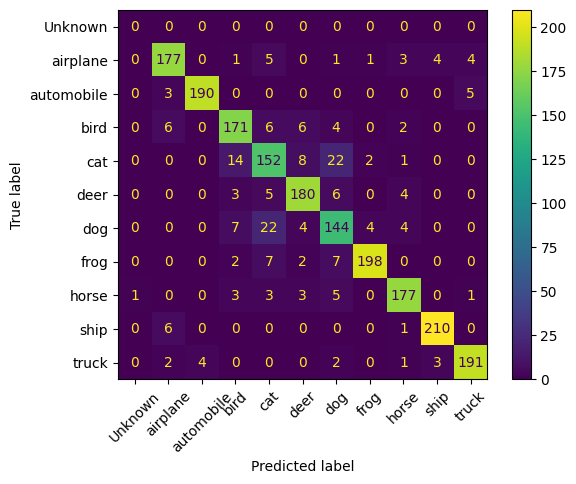

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = train_dataset.features['label'].names
cm = confusion_matrix(y_true, y_pred_filtered)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Unknown"] + labels )
disp.plot(xticks_rotation=45)